# Import Library

In [1]:
import torch as torch
import torch.optim as optim
import torch.nn as nn
import os
import torchvision
import torch.nn as nn
from torch.autograd import Variable as var
import numpy as np
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision import datasets
from PIL import Image
from glob import glob
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch.backends.cudnn.benchmark = True
print(f"Using {device} device")

Using cpu device


In [3]:
batch_size = 20
lr = 0.03
C = 3
# MoCo params
base_encoder = "resnet50"
moco_dim=10
moco_K=4096
moco_m=0.999
moco_T=0.07

In [4]:
class TwoCropsTransform:
  """Take two random crops of one image as the query and key."""

  def __init__(self, base_transform):
    self.base_transform = base_transform

  def __call__(self, x):
    q = self.base_transform(x)
    k = self.base_transform(x)
    return [q, k]

In [5]:
def saveModel(epoch, model,optimizer,loss,path):
      torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': loss
              }, path)
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

**Base Encoder Model**

In [6]:
class Resnet50Model(nn.Module):
    def __init__(self):
        super(Resnet50Model, self).__init__()

        model = models.resnet50(pretrained=False)
        modules = list(model.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.fc = nn.Sequential(nn.Linear(2048, batch_size), nn.ReLU())

    def forward(self,x):
        x = self.resnet(x)
        x = x.view(x.size(0),-1)
        x = self.fc(x)

        return x

In [7]:
@torch.no_grad()
def dequeue(queue):
    return queue[:,:(moco_K-batch_size)]

@torch.no_grad()
def enqueue(queue,k):
    return torch.cat([k, queue],dim=1)

In [8]:
# Augmentation params
augmentation = [
            transforms.RandomResizedCrop(224, scale=(0.2, 1.0)),
            transforms.Grayscale(num_output_channels=3),
            transforms.ColorJitter(0.4, 0.4, 0.4, 0.4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(0.1306, 0.3081),
        ]

# Transform the data with Two Crops Transform: output
transformer = TwoCropsTransform(transforms.Compose(augmentation))

# the training and testing set containing a pair of query and key image
trainset = datasets.MNIST(root = './data', train = True, download = True, transform = transformer) # Train set
testset = datasets.MNIST(root = './data', train = False, download = True, transform = transformer) # Test set

100%|██████████| 9912422/9912422 [00:00<00:00, 197674593.69it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 65267076.41it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 165992017.01it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 820047.73it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## subsample of the data to train moco

In [9]:
# Get the total number of samples in the dataset
total_samples = len(trainset)

# Define the size of the subset you want (e.g., 100 samples)
subset_size = 2000
# Use random_split to get a random subset
subset_indices = torch.randperm(total_samples)[:subset_size]
data100 = torch.utils.data.Subset(trainset, subset_indices)

In [10]:
train_loader = torch.utils.data.DataLoader(data100, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, num_workers=2)

# Prepare 100 samples to  fine tune Moco

1.   **tune the model on 100 samples( same sample of the baseline)**
2.   **Doing same transformation of moco for the 100 samples to will be able to extract features from them using moco**



In [11]:
transformstdmean = transforms.Compose(augmentation)
torch.manual_seed(42)

In [12]:
dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transformstdmean)

In [13]:
# Get the total number of samples in the dataset
total_samples = len(dataset)

# Define the size of the subset you want (e.g., 100 samples)
subset_size = 100

# Use random_split to get a random subset
subset_indices = torch.randperm(total_samples)[:subset_size]
data100 = torch.utils.data.Subset(dataset, subset_indices)

In [14]:
# Access class information without errors
class_to_idx = dataset.class_to_idx
print("Class to Index Mapping:", class_to_idx)

# Extract images, labels, and indices from the subset
labels, indices = zip(*[data100[i] for i in range(len(data100))])

# Convert labels to a tensor
labels_tensor = torch.tensor(indices)

Class to Index Mapping: {'0 - zero': 0, '1 - one': 1, '2 - two': 2, '3 - three': 3, '4 - four': 4, '5 - five': 5, '6 - six': 6, '7 - seven': 7, '8 - eight': 8, '9 - nine': 9}


In [15]:
# Count occurrences of each element
label_counts = torch.bincount(labels_tensor)

# Print the counts
for label, count in enumerate(label_counts):
    print(f"Label {label}: Count {count}")

Label 0: Count 7
Label 1: Count 13
Label 2: Count 12
Label 3: Count 11
Label 4: Count 7
Label 5: Count 8
Label 6: Count 14
Label 7: Count 11
Label 8: Count 5
Label 9: Count 12


In [16]:
random_state = 42 # for reproductible results
train_indices, val_indices = train_test_split(list(range(len(labels_tensor))),
                                              test_size=25,
                                              stratify=labels_tensor,
                                              random_state=random_state,
                                              shuffle=True)

In [17]:
trainset = torch.utils.data.Subset(data100, train_indices)
valset = torch.utils.data.Subset(data100, val_indices)

In [18]:
trainset

In [19]:
 #Access class information without errors
class_to_idx = dataset.class_to_idx
print("Class to Index Mapping:", class_to_idx)

# Extract images, labels, and indices from the subset
labels, indices = zip(*[trainset[i] for i in range(len(trainset))])

# Convert labels to a tensor
labels_tensor = torch.tensor(indices)
 #Count occurrences of each element
label_counts = torch.bincount(labels_tensor)

# Print the counts
for label, count in enumerate(label_counts):
    print(f"Label {label}: Count {count}")

Class to Index Mapping: {'0 - zero': 0, '1 - one': 1, '2 - two': 2, '3 - three': 3, '4 - four': 4, '5 - five': 5, '6 - six': 6, '7 - seven': 7, '8 - eight': 8, '9 - nine': 9}
Label 0: Count 5
Label 1: Count 10
Label 2: Count 9
Label 3: Count 8
Label 4: Count 5
Label 5: Count 6
Label 6: Count 11
Label 7: Count 8
Label 8: Count 4
Label 9: Count 9


In [20]:
batch_size=20

In [21]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# Transfer Learning with top 5 accuracy

**Load Model**

In [22]:
model =models.__dict__["resnet50"]()

In [23]:
for name, param in model.named_parameters():
  if param.requires_grad and  not 'fc' in name:
    param.requires_grad = False
    # here we freeze the training in the conv layers

In [24]:
model.fc = nn.Linear(2048, 10) # TODO: change output size

In [27]:
checkpoint = torch.load('/content/drive/MyDrive/Deep Learning M2DS/Project/moco_model.pth', map_location=torch.device('cpu'))
state_dict = checkpoint["state_dict"]
for k in list(state_dict.keys()):
    # retain only encoder_q up to before the embedding layer
    if k.startswith("module.encoder_q") and not k.startswith(
                    "module.encoder_q.fc"):
    # remove prefix
      state_dict[k[len("module.encoder_q.") :]] = state_dict[k]
    # delete renamed or unused k
    del state_dict[k]

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:
model.load_state_dict(state_dict, strict=False)

_IncompatibleKeys(missing_keys=['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.conv3.weight', 'layer1.0.bn3.weight', 'layer1.0.bn3.bias', 'layer1.0.bn3.running_mean', 'layer1.0.bn3.running_var', 'layer1.0.downsample.0.weight', 'layer1.0.downsample.1.weight', 'layer1.0.downsample.1.bias', 'layer1.0.downsample.1.running_mean', 'layer1.0.downsample.1.running_var', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.conv2.weight', 'layer1.1.bn2.weight', 'layer1.1.bn2.bias', 'layer1.1.bn2.running_mean', 'layer1.1.bn2.running_var', 'layer1.1.conv3.weight', 'layer1.1.bn3.weight', 'layer1.1.bn3.bias', 'layer1.1.bn3.runni

In [29]:
#Check weights names
params = model.state_dict()
params.keys()

odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.0.conv3.weight', 'layer1.0.bn3.weight', 'layer1.0.bn3.bias', 'layer1.0.bn3.running_mean', 'layer1.0.bn3.running_var', 'layer1.0.bn3.num_batches_tracked', 'layer1.0.downsample.0.weight', 'layer1.0.downsample.1.weight', 'layer1.0.downsample.1.bias', 'layer1.0.downsample.1.running_mean', 'layer1.0.downsample.1.running_var', 'layer1.0.downsample.1.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.we

In [30]:
model= model.to(device) # to device

In [31]:
epoch=5
epochs=100

In [32]:
def train_val(net, data_loader, train_optimizer):
    is_train = train_optimizer is not None
    net.train() if is_train else net.eval()

    total_loss, total_correct_1,total_correct_2,total_correct_3,total_correct_4, total_correct_5, total_num,  data_bar = 0.0,0.0,0.0,0.0, 0.0, 0.0, 0, tqdm(data_loader)
    with (torch.enable_grad() if is_train else torch.no_grad()):
        for data, target in data_bar:
            data, target = data.to(device), target.to(device)
            out = net(data)
            loss = loss_criterion(out, target)

            if is_train:
                train_optimizer.zero_grad()
                loss.backward()
                train_optimizer.step()

            total_num += data.size(0)
            total_loss += loss.item() * data.size(0)
            prediction = torch.argsort(out, dim=-1, descending=True)
            total_correct_1 += torch.sum((prediction[:, 0:1] == target.unsqueeze(dim=-1)).any(dim=-1).float()).item()
            total_correct_2 += torch.sum((prediction[:, 0:2] == target.unsqueeze(dim=-1)).any(dim=-1).float()).item()
            total_correct_3 += torch.sum((prediction[:, 0:3] == target.unsqueeze(dim=-1)).any(dim=-1).float()).item()
            total_correct_4 += torch.sum((prediction[:, 0:4] == target.unsqueeze(dim=-1)).any(dim=-1).float()).item()
            total_correct_5 += torch.sum((prediction[:, 0:5] == target.unsqueeze(dim=-1)).any(dim=-1).float()).item()
            data_bar.set_description('{} Epoch: [{}/{}] Loss: {:.4f} ACC@1: {:.2f}% ACC@2: {:.2f}% ACC@3: {:.2f}% ACC@4: {:.2f}% ACC@5: {:.2f}%'
                                     .format('Train' if is_train else 'Validation', epoch, epochs, total_loss / total_num,
                                             total_correct_1 / total_num * 100, total_correct_2 / total_num * 100,  total_correct_1 / total_num * 100, total_correct_3 / total_num * 100, total_correct_4 / total_num * 100, total_correct_5 / total_num * 100))

    return total_loss / total_num, total_correct_1 / total_num * 100, total_correct_2 / total_num * 100,total_correct_3 / total_num * 100, total_correct_4 / total_num * 100,total_correct_5 / total_num * 100

In [33]:
import pandas as pd

In [34]:
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3, weight_decay=1e-6)
loss_criterion = nn.CrossEntropyLoss()
results = {'train_loss': [], 'train_acc@1': [], 'train_acc@2': [],'train_acc@3': [], 'train_acc@4': [],'train_acc@5': [],
               'val_loss': [],'val_acc@1': [], 'val_acc@2': [],'val_acc@3': [], 'val_acc@4': [],'val_acc@5': []}

best_acc = 0.0
for epoch in range(1, epochs + 1):
        train_loss, train_acc_1,train_acc_2,train_acc_3,train_acc_4, train_acc_5 = train_val(model, trainloader, optimizer)
        results['train_loss'].append(train_loss)
        results['train_acc@1'].append(train_acc_1)
        results['train_acc@2'].append(train_acc_2)
        results['train_acc@3'].append(train_acc_3)
        results['train_acc@4'].append(train_acc_4)
        results['train_acc@5'].append(train_acc_5)
        with torch.no_grad():
          val_loss, val_acc_1,val_acc_2,val_acc_3,val_acc_4, val_acc_5 = train_val(model, valloader, None)
          results['val_loss'].append(val_loss)
          results['val_acc@1'].append(val_acc_1)
          results['val_acc@2'].append(val_acc_2)
          results['val_acc@3'].append(val_acc_3)
          results['val_acc@4'].append(val_acc_4)
          results['val_acc@5'].append(val_acc_5)
        # save statistics
          data_frame = pd.DataFrame(data=results, index=range(1, epoch + 1))
          if val_acc_1 > best_acc:
            best_acc = val_acc_1

Train Epoch: [1/100] Loss: 3.4768 ACC@1: 6.67% ACC@2: 13.33% ACC@3: 6.67% ACC@4: 21.33% ACC@5: 30.67%: 100%|██████████| 8/8 [00:17<00:00,  2.14s/it]
Validation Epoch: [1/100] Loss: 2.3317 ACC@1: 12.00% ACC@2: 24.00% ACC@3: 12.00% ACC@4: 40.00% ACC@5: 48.00%: 100%|██████████| 2/2 [00:05<00:00,  2.51s/it]
Train Epoch: [2/100] Loss: 3.1358 ACC@1: 4.00% ACC@2: 20.00% ACC@3: 4.00% ACC@4: 33.33% ACC@5: 45.33%: 100%|██████████| 8/8 [00:17<00:00,  2.24s/it]
Validation Epoch: [2/100] Loss: 2.3512 ACC@1: 12.00% ACC@2: 28.00% ACC@3: 12.00% ACC@4: 44.00% ACC@5: 44.00%: 100%|██████████| 2/2 [00:06<00:00,  3.03s/it]
Train Epoch: [3/100] Loss: 2.6148 ACC@1: 20.00% ACC@2: 28.00% ACC@3: 20.00% ACC@4: 38.67% ACC@5: 50.67%: 100%|██████████| 8/8 [00:18<00:00,  2.37s/it]
Validation Epoch: [3/100] Loss: 2.3842 ACC@1: 16.00% ACC@2: 28.00% ACC@3: 16.00% ACC@4: 36.00% ACC@5: 48.00%: 100%|██████████| 2/2 [00:05<00:00,  2.94s/it]
Train Epoch: [4/100] Loss: 2.8283 ACC@1: 10.67% ACC@2: 18.67% ACC@3: 10.67% ACC@4: 

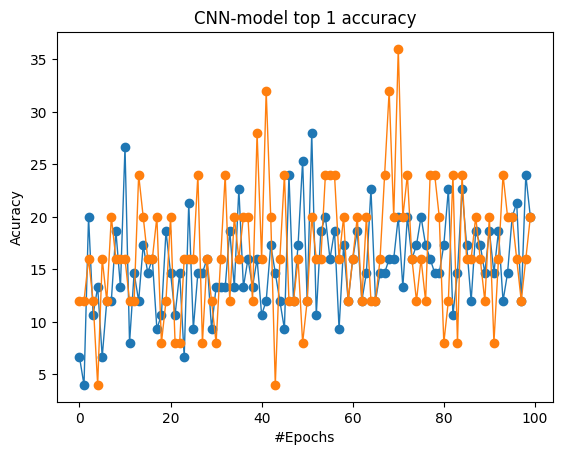

In [36]:
plt.plot(results['train_acc@1'], label='training set', marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.plot(results['val_acc@1'], label='validation set', marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.title("CNN-model top 1 accuracy")
plt.xlabel('#Epochs')
plt.ylabel('Acuracy')
plt.show()

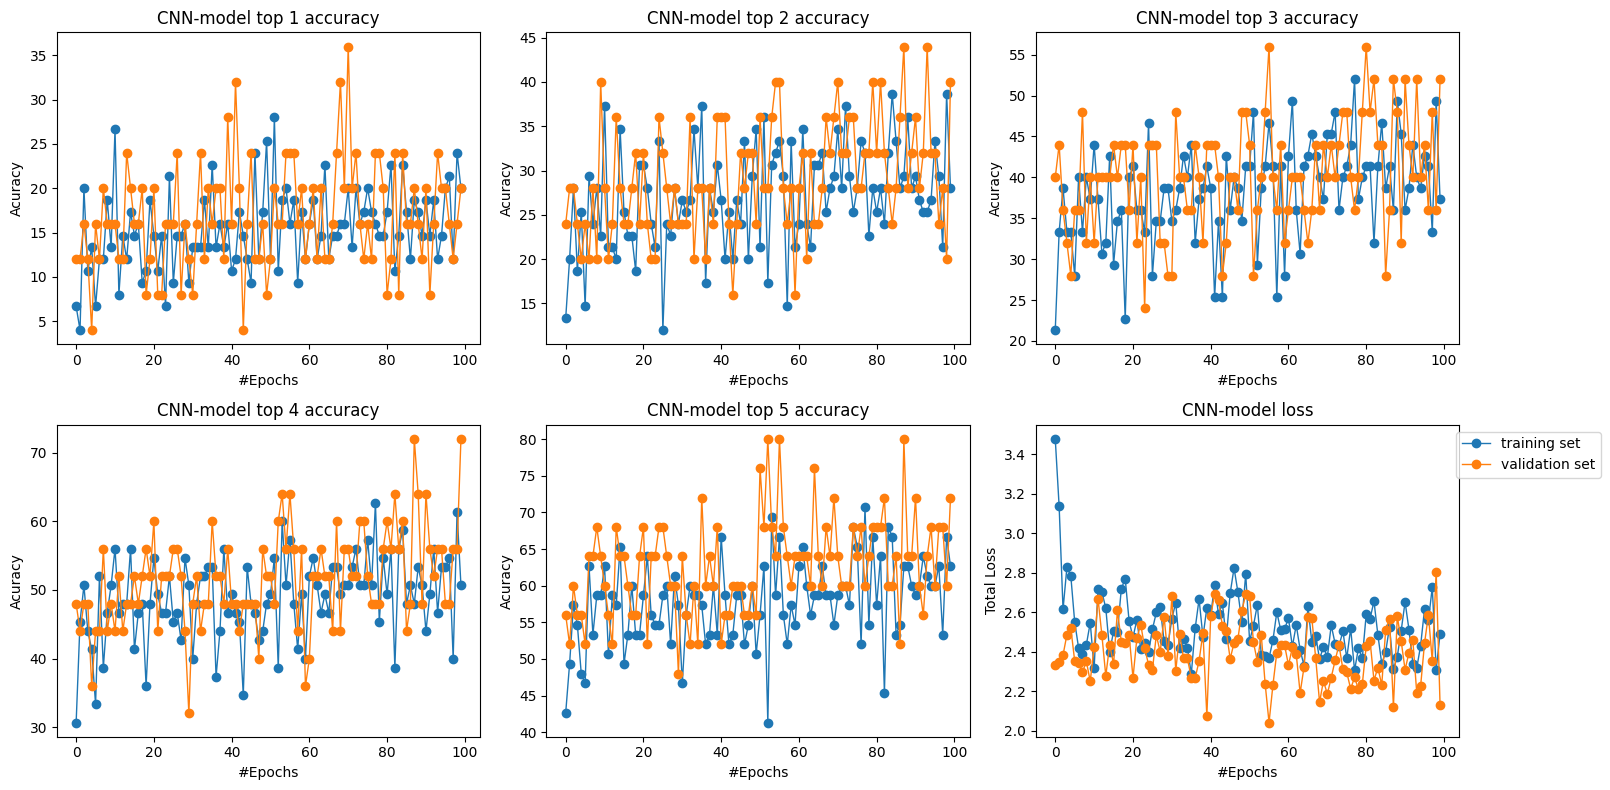

In [35]:
fig = plt.figure(figsize = (16, 8))
plt.subplot(2, 3, 1)
plt.plot(results['train_acc@1'], label='training set', marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.plot(results['val_acc@1'], label='validation set', marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.title("CNN-model top 1 accuracy")
plt.xlabel('#Epochs')
plt.ylabel('Acuracy')
plt.subplot(2, 3, 2)
plt.plot(results['train_acc@2'], label='training set', marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.plot(results['val_acc@2'], label='validation set', marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.title("CNN-model top 2 accuracy")
plt.xlabel('#Epochs')
plt.ylabel('Acuracy')
plt.subplot(2, 3, 3)
plt.plot(results['train_acc@3'], label='training set', marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.plot(results['val_acc@3'], label='validation set', marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.title("CNN-model top 3 accuracy")
plt.xlabel('#Epochs')
plt.ylabel('Acuracy')
plt.subplot(2, 3, 4)
plt.plot(results['train_acc@4'], label='training set', marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.plot(results['val_acc@4'], label='validation set', marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.title("CNN-model top 4 accuracy")
plt.xlabel('#Epochs')
plt.ylabel('Acuracy')
plt.subplot(2, 3, 5)
plt.plot(results['train_acc@5'], label='training set', marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.plot(results['val_acc@5'], label='validation set', marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.title("CNN-model top 5 accuracy")
plt.xlabel('#Epochs')
plt.ylabel('Acuracy')
plt.subplot(2, 3, 6)
plt.legend(bbox_to_anchor=( 1., 1.))
plt.plot(results['train_loss'], label='training set',marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.plot(results['val_loss'], label='validation set',marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.title("CNN-model loss")
plt.xlabel('#Epochs')
plt.ylabel('Total Loss')
plt.legend(bbox_to_anchor=( 1.35, 1.))
plt.tight_layout()
plt.show()

# Evaluation on test set

**Test SET**

In [37]:
transformstdmean = transforms.Compose(augmentation)
torch.manual_seed(42)

In [38]:
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                        download=True, transform=transformstdmean)

In [39]:
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [40]:
# Get the total number of samples in the dataset
total_samples = len(testset)

# Define the size of the subset you want (e.g., 100 samples)
subset_size = 200
# Use random_split to get a random subset
subset_indices = torch.randperm(total_samples)[:subset_size]
testdata100 = torch.utils.data.Subset(trainset, subset_indices)

In [41]:
test_loader = torch.utils.data.DataLoader(data100, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

In [43]:
output_fn = torch.nn.Softmax(dim=1) # we instantiate the softmax activation function for the output probabilities
model.eval()
with torch.no_grad():
  total_loss, total_correct_1, total_correct_2, total_correct_3,total_correct_4, total_correct_5, total_num, data_bar = 0.0, 0.0,0.0,0.0,0.0, 0.0, 0, tqdm(test_loader)
  for inputs, labels in data_bar:
    inputs=inputs.to(device)
    labels=labels.to(device)
    t_out = model(x=inputs)
    total_num += inputs.size(0)
    prediction = torch.argsort(t_out, dim=-1, descending=True)
    total_correct_5 += torch.sum((prediction[:, 0:5] == labels.unsqueeze(dim=-1)).any(dim=-1).float()).item()
    total_correct_4 += torch.sum((prediction[:, 0:4] == labels.unsqueeze(dim=-1)).any(dim=-1).float()).item()
    total_correct_3 += torch.sum((prediction[:, 0:3] == labels.unsqueeze(dim=-1)).any(dim=-1).float()).item()
    total_correct_2 += torch.sum((prediction[:, 0:2] == labels.unsqueeze(dim=-1)).any(dim=-1).float()).item()
    total_correct_1 += torch.sum((prediction[:, 0:1] == labels.unsqueeze(dim=-1)).any(dim=-1).float()).item()
print("Test accuracy 5: {}".format(total_correct_5 / total_num * 100),'\n', "Test accuracy 4: {}".format(total_correct_4 / total_num * 100)
                  ,'\n', "Test accuracy 3: {}".format(total_correct_3 / total_num * 100),'\n', "Test accuracy 2: {}".format(total_correct_3 / total_num * 100),'\n',
                                                                                                                            "Test accuracy 1: {}".format(total_correct_1 / total_num * 100))

100%|██████████| 5/5 [00:26<00:00,  5.37s/it]

Test accuracy 5: 67.0 
 Test accuracy 4: 61.0 
 Test accuracy 3: 48.0 
 Test accuracy 2: 48.0 
 Test accuracy 1: 28.000000000000004


# Hyperparameter tunning

In [44]:
! pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.8 MB/s eta 0:00:00


In [45]:
import optuna

def objective(trial):
    # objective function to run at each trial.

    # Specify the hyperparameters to search, their type and the value range:
    lr = trial.suggest_loguniform("lr", 1e-4, 1e-2) # learning rate
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "Adadelta","Adagrad"])
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
    batch_size=trial.suggest_int("batch_size", 10, 20, step=10)

    # Train the model
    train_loss, train_acc_1,train_acc_2, train_acc_3,train_acc_4, train_acc_5 = train_val(model, trainloader, optimizer)
    val_loss, val_acc_1,val_acc_2, val_acc_3,val_acc_4, val_acc_5 = train_val(model, valloader, None)
    # Must return the metric you want to maximize or minimize.
    return val_acc_1

In [46]:
# Create a search study
study = optuna.create_study()
# Run the search
study.optimize(objective, n_trials=5)

[I 2024-01-09 03:23:37,620] A new study created in memory with name: no-name-36a4634f-88e4-4243-b9d9-dcada45de59b
<ipython-input-45-91d753028611>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2) # learning rate
Train Epoch: [100/100] Loss: 2.3346 ACC@1: 17.33% ACC@2: 33.33% ACC@3: 17.33% ACC@4: 42.67% ACC@5: 57.33%: 100%|██████████| 8/8 [00:42<00:00,  5.32s/it]
Validation Epoch: [100/100] Loss: 2.2460 ACC@1: 20.00% ACC@2: 32.00% ACC@3: 20.00% ACC@4: 44.00% ACC@5: 56.00%: 100%|██████████| 2/2 [00:07<00:00,  3.69s/it]
[I 2024-01-09 03:24:27,599] Trial 0 finished with value: 20.0 and parameters: {'lr': 0.00041018405033536724, 'optimizer': 'Adagrad', 'batch_size': 10}. Best is trial 0 with value: 20.0.
Train Epoch: [100/100] Loss: 2.2497 ACC@1: 24.00% ACC@2: 33.33% ACC@3: 24.00% ACC@4

In [47]:
# Check best params
study.best_params

{'lr': 0.00010245009752612, 'optimizer': 'Adagrad', 'batch_size': 20}